# Trabalho Prático nº 1 - Análise de Expressões Faciais em Vídeo
## Tópicos de Ciência dos Dados - MECD (2023/2024)
## Parte A

- Carlos Matos - 2020245868
- Mariana Magueijo - 2020246886

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
from scipy.spatial import distance
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ReliefF import ReliefF
from skfeature.function.similarity_based import fisher_score
from scipy.stats import norm


##### Funções auxiliares

In [3]:
number_emotions = {'01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad', '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'}

In [4]:
def one_file_coordinates(file):
    landmark = 68
    f = pd.read_csv("dataset/" + file)
    frame_dict = {}
    for nl in range(f.shape[0]):
        if pd.isna(f["frame"][nl]):
            break
        for i in range(landmark):
            
            if nl in frame_dict:
                frame_dict[nl].append([f["x_" + str(i)][nl], f["y_" + str(i)][nl]])
            else:
                frame_dict[nl] = [[f["x_" + str(i)][nl], f["y_" + str(i)][nl]]]
    return frame_dict

In [5]:
def file_coordinates(path):
    files = os.listdir(path)
    landmark = 68
    all_info = {}
    for file in files:
        f = pd.read_csv("dataset/" + file)
        frame_dict = {}
        for nl in range(f.shape[0]):
            if pd.isna(f["frame"][nl]):
                break
            for i in range(landmark):
                
                if nl in frame_dict:
                    frame_dict[nl].append([f["x_" + str(i)][nl], f["y_" + str(i)][nl]])
                else:
                    frame_dict[nl] = [[f["x_" + str(i)][nl], f["y_" + str(i)][nl]]]
        all_info[file] = frame_dict
    with open("dicionary_inicial.pkl", 'wb') as arq:
        pickle.dump(all_info, arq)

    return all_info

if os.path.exists("dicionary_inicial.pkl"):
    with open("dicionary_inicial.pkl", 'rb') as arq:
        all_d = pickle.load(arq)
else:
    all_d = file_coordinates("dataset/")

#print(all_d)

#### 2. Extração do conteúdo dos ficheiros do dataset
##### 2.1 Tratamento do dataset para um dicionário

In [6]:
def read_files(path):
    files = os.listdir(path)
    subject_emotions= {}

    for file in files:
        divide = file.split('-')
        last = divide[-1]
        name = os.path.splitext(last)[0]
        divide[-1] = name

        actor = "Actor " + str(int(name))

        if actor in subject_emotions:
            emotion = number_emotions[divide[2]]
            if emotion in subject_emotions[actor]:
                subject_emotions[actor][emotion].append(file)
            else:
                subject_emotions[actor][emotion] = [file]
        else:
            subject_emotions[actor] = {number_emotions[divide[2]]: [file]} 

    return subject_emotions
        
all_subject_emotions = read_files("dataset")
print(all_subject_emotions)


{'Actor 1': {'Neutral': ['01-01-01-01-01-01-01.csv', '01-01-01-01-01-02-01.csv', '01-01-01-01-02-01-01.csv', '01-01-01-01-02-02-01.csv', '01-02-01-01-01-01-01.csv', '01-02-01-01-01-02-01.csv', '01-02-01-01-02-01-01.csv', '01-02-01-01-02-02-01.csv'], 'Calm': ['01-01-02-01-01-01-01.csv', '01-01-02-01-01-02-01.csv', '01-01-02-01-02-01-01.csv', '01-01-02-01-02-02-01.csv', '01-01-02-02-01-01-01.csv', '01-01-02-02-01-02-01.csv', '01-01-02-02-02-01-01.csv', '01-01-02-02-02-02-01.csv', '01-02-02-01-01-01-01.csv', '01-02-02-01-01-02-01.csv', '01-02-02-01-02-01-01.csv', '01-02-02-01-02-02-01.csv', '01-02-02-02-01-01-01.csv', '01-02-02-02-01-02-01.csv', '01-02-02-02-02-01-01.csv', '01-02-02-02-02-02-01.csv'], 'Happy': ['01-01-03-01-01-01-01.csv', '01-01-03-01-01-02-01.csv', '01-01-03-01-02-01-01.csv', '01-01-03-01-02-02-01.csv', '01-01-03-02-01-01-01.csv', '01-01-03-02-01-02-01.csv', '01-01-03-02-02-01-01.csv', '01-01-03-02-02-02-01.csv', '01-02-03-01-01-01-01.csv', '01-02-03-01-01-02-01.csv', '0

##### 2.2 Coordenadas e preenchimento a NaN

In [7]:
def subject_routine(subject_emotions):
    subject_data = {}
    landmarks = 68 * 2
    max_frames = 0
    for subject in subject_emotions:
        actor = subject
        count_files = 0
        for emotion in subject_emotions[subject]:
            count_files += len(subject_emotions[subject][emotion])
            for file in subject_emotions[subject][emotion]:
                string = "dataset/" + file
                nl = (pd.read_csv(string)).shape[0]
                if nl > max_frames:
                    max_frames = nl
        subject_data[actor] = [count_files, landmarks]
    for subject in subject_data:
        subject_data[subject].append(max_frames)

    return subject_data, max_frames

all_subject_data, all_max_frames = subject_routine(all_subject_emotions)
print(all_subject_data)


{'Actor 1': [104, 136, 191], 'Actor 2': [104, 136, 191], 'Actor 3': [104, 136, 191], 'Actor 4': [104, 136, 191], 'Actor 5': [104, 136, 191], 'Actor 6': [104, 136, 191], 'Actor 7': [104, 136, 191], 'Actor 8': [104, 136, 191], 'Actor 9': [104, 136, 191], 'Actor 10': [104, 136, 191], 'Actor 11': [104, 136, 191], 'Actor 12': [104, 136, 191], 'Actor 13': [104, 136, 191], 'Actor 14': [104, 136, 191], 'Actor 15': [104, 136, 191], 'Actor 16': [104, 136, 191], 'Actor 17': [104, 136, 191], 'Actor 18': [60, 136, 191], 'Actor 19': [104, 136, 191], 'Actor 20': [104, 136, 191], 'Actor 21': [104, 136, 191], 'Actor 22': [104, 136, 191], 'Actor 23': [104, 136, 191], 'Actor 24': [104, 136, 191]}


In [8]:
def complete_files(path, max_frames):
    files = os.listdir(path)

    for file in files:
        string = "dataset/" + file
        f = pd.read_csv(string)
        nl = f.shape[0]
        add_lines = max_frames - nl
        if add_lines > 0:
            nan_lines = [None for _ in range(add_lines)]
            new_file = pd.concat([f, pd.DataFrame(nan_lines)], ignore_index=True)
            new_file.to_csv(string, index=False)

if len(pd.read_csv("dataset/01-01-01-01-01-01-01.csv")) != all_max_frames:
    complete_files("dataset", all_max_frames)

##### 2.3 Emoção - Nome do Ficheiro

In [9]:
def emotion_file(subject_emotions):
    ef = []
    
    for key1, value1 in subject_emotions.items():
        for key2, value2 in value1.items():
            ef.extend([key2, emotion] for emotion in value2)
    
    return ef

all_ef = emotion_file(all_subject_emotions)
print(all_ef)

[['Neutral', '01-01-01-01-01-01-01.csv'], ['Neutral', '01-01-01-01-01-02-01.csv'], ['Neutral', '01-01-01-01-02-01-01.csv'], ['Neutral', '01-01-01-01-02-02-01.csv'], ['Neutral', '01-02-01-01-01-01-01.csv'], ['Neutral', '01-02-01-01-01-02-01.csv'], ['Neutral', '01-02-01-01-02-01-01.csv'], ['Neutral', '01-02-01-01-02-02-01.csv'], ['Calm', '01-01-02-01-01-01-01.csv'], ['Calm', '01-01-02-01-01-02-01.csv'], ['Calm', '01-01-02-01-02-01-01.csv'], ['Calm', '01-01-02-01-02-02-01.csv'], ['Calm', '01-01-02-02-01-01-01.csv'], ['Calm', '01-01-02-02-01-02-01.csv'], ['Calm', '01-01-02-02-02-01-01.csv'], ['Calm', '01-01-02-02-02-02-01.csv'], ['Calm', '01-02-02-01-01-01-01.csv'], ['Calm', '01-02-02-01-01-02-01.csv'], ['Calm', '01-02-02-01-02-01-01.csv'], ['Calm', '01-02-02-01-02-02-01.csv'], ['Calm', '01-02-02-02-01-01-01.csv'], ['Calm', '01-02-02-02-01-02-01.csv'], ['Calm', '01-02-02-02-02-01-01.csv'], ['Calm', '01-02-02-02-02-02-01.csv'], ['Happy', '01-01-03-01-01-01-01.csv'], ['Happy', '01-01-03-01-0

##### 2.4 e 2.5 Representação dos frames em imagem

Representação do ficheiro 01-01-01-01-01-01-01.csv para 1 frames


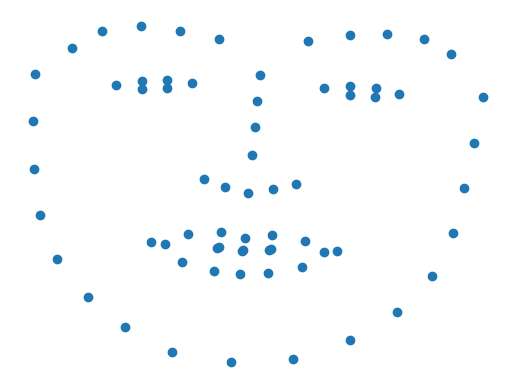

In [10]:
def show_expression(d, file, frames):
    matrix_x = []
    matrix_y = []
    for frame in range(frames):
        for coordinates in d[file][frame]:
            matrix_x.append(coordinates[0])
            matrix_y.append(coordinates[1])
        plt.scatter(matrix_x, np.multiply(matrix_y, -1))
        plt.axis('off')
    plt.show()
    
all_frames = 1
if all_frames > all_max_frames:
    frames = all_max_frames
f = "01-01-01-01-01-01-01.csv"
print("Representação do ficheiro " + f + " para " + str(all_frames) + " frames")
show_expression(all_d, f, all_frames)

#### 3. Análise e tratamento de Outliers
##### 3.1 Normalização das coordenadas

In [11]:
def nomalize_coordinates(d, x_max, y_max, ref):    
    for file in d.keys():
        for frame in d[file]:
            x_ref = d[file][frame][ref][0]
            y_ref = d[file][frame][ref][1]
            for coordenates in d[file][frame]:
                coordenates[0] =  (coordenates[0] - x_ref) / x_max
                coordenates[1] =  (coordenates[1] - y_ref) / y_max
    
    with open("dicionary_normalized.pkl", 'wb') as arq:
        pickle.dump(d, arq)
    return d 

if os.path.exists("dicionary_normalized.pkl"):
    with open("dicionary_normalized.pkl", 'rb') as arq:
        all_d_normalized = pickle.load(arq)
else:
    all_d_normalized = nomalize_coordinates(all_d, 1280, 720, 27)
    
#print(all_d_normalized)

##### 3.2 Boxplot

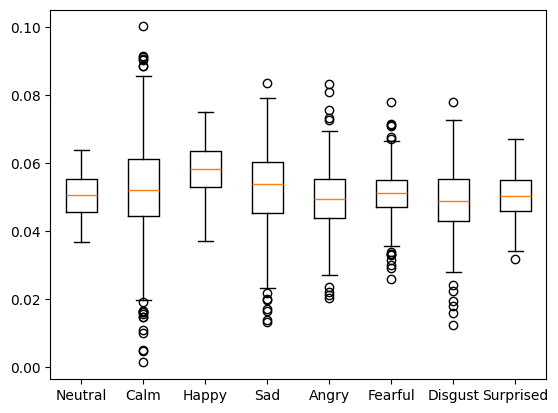

In [12]:
def boxplot(d_normalized, coordinate, landmark, plot):
    emotions = {"01" : [], "02" : [], "03" : [], "04" : [], "05": [], "06" : [], "07" : [], "08" : []}
    x_labels = np.array(['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised'])
    for file in d_normalized.keys():
        em = file.split('-')[2]
        value = 0
        for frame in d_normalized[file]:
            value += d_normalized[file][frame][landmark][coordinate]
        emotions[em].append(value/len(d_normalized[file]))
    data = [emotions["01"], emotions["02"], emotions["03"], emotions["04"], emotions["05"], emotions["06"], emotions["07"], emotions["08"]] 
    if plot:
        plt.boxplot(data, vert=True, labels=x_labels) #orientaçao vertical
        plt.show()
              
    return emotions    

all_d_boxplot = boxplot(all_d_normalized, 0, 54, True)
 

##### 3.3 Densidade dos Outliers

In [13]:
def density_outliers(data):
    data.sort()
    num_data = len(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    iqr = q3 - q1
    lim_superior = q3 + 1.5 * iqr
    lim_inferior = q1 - 1.5 * iqr

    outliers = [x for x in data if x > lim_superior or x < lim_inferior]
    num_outliers = len(outliers)

    density = (num_outliers/num_data) * 100
    return density, outliers


In [14]:
def total_densities(d_normalized):
    densities = {}
    for coordinate in range(2):
        for i in range(68):
            emotions = boxplot(d_normalized, coordinate, i, False)
            for em in emotions:
                if em in densities:
                    densities[em].append(density_outliers(emotions[em])[0])
                else:
                    densities[em] = [density_outliers(emotions[em])[0]]
    return densities

all_densities = total_densities(all_d_normalized)

print("Densidade de outliers no dataset")
for em in all_densities:
    print("--")
    print("Emoção: " + number_emotions[em] + "\nMédia: ", np.mean(all_densities[em]), "\nDesvio padrão: ", np.std(all_densities[em]))
    

Densidade de outliers no dataset
--
Emoção: Neutral
Média:  1.865613266583229 
Desvio padrão:  3.8351484361869086
--
Emoção: Calm
Média:  2.9548654568210266 
Desvio padrão:  2.6453925688387723
--
Emoção: Happy
Média:  1.390409887359199 
Desvio padrão:  2.0484429092565386
--
Emoção: Sad
Média:  1.4842772215269087 
Desvio padrão:  1.859621117860873
--
Emoção: Angry
Média:  2.213704630788486 
Desvio padrão:  2.2425939911206227
--
Emoção: Fearful
Média:  2.82970901126408 
Desvio padrão:  2.1438955369596444
--
Emoção: Disgust
Média:  2.5160845588235294 
Desvio padrão:  2.0761932900413864
--
Emoção: Surprised
Média:  1.6582414215686274 
Desvio padrão:  2.2914248684219363


##### 3.4 Desidade de Outliers usando Z-Score

In [15]:
def zscore_outliers(array, k):
    mean = np.mean(array)
    std = np.std(array)
    outliers = []
    not_outliers = []
    for x in range(len(array)):
        z = abs((array[x] - mean)/std)
        if z >= k:
            outliers.append(x)
        else:
            not_outliers.append(x)
    return outliers, not_outliers

##### 3.5 Mostra a expressão com outliers a vermelho

Outliers do ficheiro 01-01-02-01-01-01-01.csv para k = 1


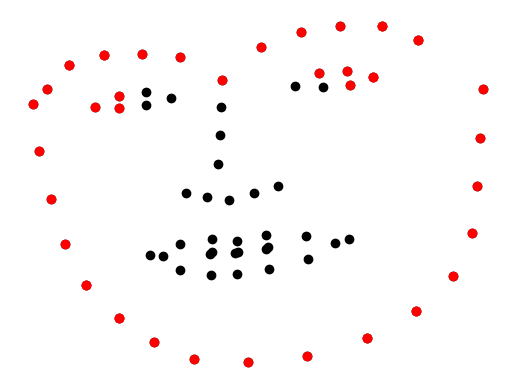

Outliers do ficheiro 01-01-02-01-01-01-01.csv para k = 2


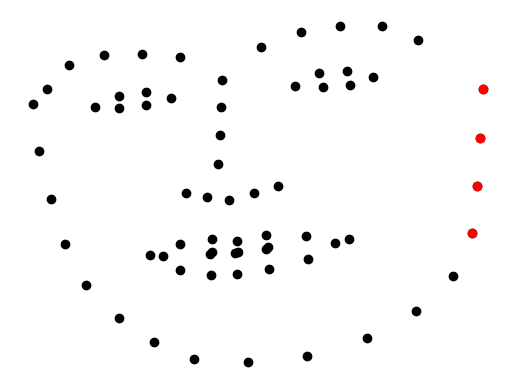

Outliers do ficheiro 01-01-02-01-01-01-01.csv para k = 3


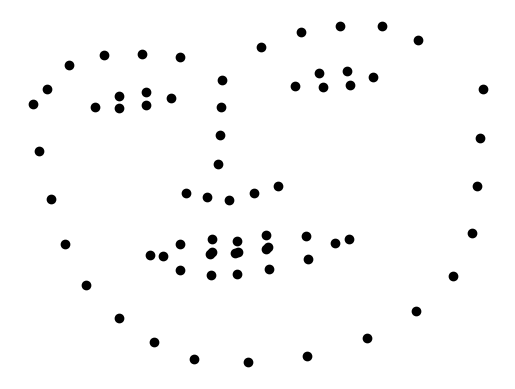

In [16]:
def expression_outliers_zscore(d_normalized, file, frames, k):
    for frame in range(frames):
        matrix_x = []
        matrix_y = []
        for coordinates in d_normalized[file][frame]:
            matrix_x.append(coordinates[0])
            matrix_y.append(coordinates[1])

        matrix_x = np.array(matrix_x)
        matrix_y = np.array(matrix_y)
        outliers_x = zscore_outliers(matrix_x, k)[0]
        outliers_y = zscore_outliers(matrix_y, k)[0]
        
        len_img = max(matrix_y)
        matrix_y = len_img - matrix_y
        plt.scatter(matrix_x, matrix_y, c = 'black')
        plt.scatter(matrix_x[outliers_x], matrix_y[outliers_x], c = 'red')
        plt.scatter(matrix_x[outliers_y], matrix_y[outliers_y], c = 'red')
        plt.axis('off')
        plt.show()

k = 1
f = "01-01-02-01-01-01-01.csv"
print("Outliers do ficheiro " + f + " para k = " + str(k))
expression_outliers_zscore(all_d_normalized, f, 1, k)
k = 2
print("Outliers do ficheiro " + f + " para k = " + str(k))
expression_outliers_zscore(all_d_normalized, f, 1, k)
k = 3
print("Outliers do ficheiro " + f + " para k = " + str(k))
expression_outliers_zscore(all_d_normalized, f, 1, k)

# k = 3
# for f in all_d_normalized:
#     print("Outliers do ficheiro " + f + " para k = " + str(k))
#     expression_outliers_zscore(all_d_normalized, f, 1, k)

Em cima estão apresentados os plots para diferentes k's para o ficheiro "01-01-02-01-01-01-01", e como podemos observar, apesar de nos ser pedido no enunciado para correr para valores de k a partir de 3, apenas apresenta outliers para valores inferiores a 2. 

Isto foi testado para vários ficheiros, e nenhum obteve outiliers para k = 3.
Porém para k = 2 existem alguns outliers, porém são poucos.

##### 3.6 Comparação de resultados entre o 3.2 e o 3.5

No ponto 3.2 apresentamos um bosplot em que no eixo dos x encontram-se as emoções e nesse gráfico é possível ver os outliers para uma variável de cada emoção. 

No ponto 3.5 é representada a emoção "Neutral" do ficheiro escolhido, com os respetivos outliers calculados com o teste Z-score.


tirar um conclusão

##### 3.7 Algoritmo k-means

In [17]:
def plot_clusters(centrois, group_centroids):

    matrix_x = [c[0] for c in group_centroids]
    matrix_y = [c[1] for c in group_centroids]
    len_img = max(matrix_y)
    matrix_y = len_img - matrix_y
    plt.scatter(matrix_x, matrix_y, color='red', marker='x')
    plt.scatter(centrois[0], centrois[1], marker='o')
    plt.show()

In [18]:
def cluster_groups(all_coordenates, centroids):
    group_centroids = {}
    for i in range(len(centroids)):
        group_centroids[i] = []

    for coordenate in all_coordenates:
        aux = []
        for centroid in centroids:
            aux.append(distance.euclidean(centroid, coordenate))
        i = aux.index(min(aux))
        group_centroids[i].append(coordenate)
    return group_centroids

2 clusters com o algoritmo kmeans
Centroide 1:  [-0.01960937500000002, 0.14500000000000005]
Cluster 1:  [[-0.10320312499999998, 0.030694444444444476], [-0.09984374999999997, 0.09125000000000007], [-0.09320312499999997, 0.15236111111111117], [-0.08546874999999998, 0.2101388888888889], [-0.07406249999999996, 0.26361111111111113], [-0.05625, 0.30652777777777784], [-0.03703124999999998, 0.3368055555555556], [-0.015156249999999982, 0.35833333333333334], [0.0140625, 0.36277777777777787], [0.04632812500000005, 0.35527777777777786], [0.07914062500000005, 0.3313888888888889], [0.10593750000000002, 0.2972222222222222], [0.12585937500000002, 0.2513888888888889], [0.136328125, 0.19638888888888895], [-0.09507812499999999, 0.01083333333333335], [-0.001171875, 0.07055555555555557], [-0.0018749999999999821, 0.1077777777777778], [-0.01960937500000002, 0.14500000000000005], [-0.008281250000000018, 0.14986111111111117], [0.0036718750000000354, 0.15361111111111114], [0.01765625000000002, 0.144861111111111

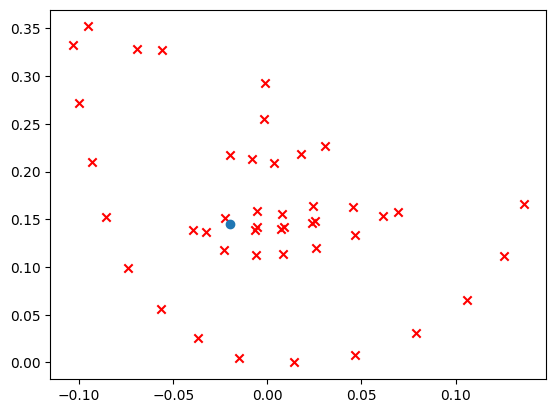

--
Centroide 2:  [0.07000000000000002, 0.005694444444444476]
Cluster 2:  [[0.13890625000000006, 0.1365277777777778], [0.14078125000000002, 0.07430555555555556], [0.142578125, 0.01097222222222227], [-0.08335937499999999, -0.019305555555555524], [-0.06398437499999998, -0.031805555555555524], [-0.04343750000000002, -0.03402777777777774], [-0.023046875, -0.029999999999999954], [0.02156250000000002, -0.043194444444444396], [0.04312500000000004, -0.06124999999999995], [0.06453125000000001, -0.06930555555555552], [0.087109375, -0.06930555555555552], [0.10695312499999998, -0.052083333333333294], [0.0, 0.0], [-0.000390625, 0.035000000000000066], [-0.05632812500000002, 0.019861111111111128], [-0.04156249999999995, 0.015277777777777777], [-0.027734375, 0.02361111111111111], [-0.04156249999999995, 0.0318055555555556], [0.03984375, 0.007638888888888889], [0.05296875000000005, -0.00916666666666662], [0.068359375, -0.012222222222222159], [0.08257812500000003, -0.0036111111111110637], [0.0700000000000

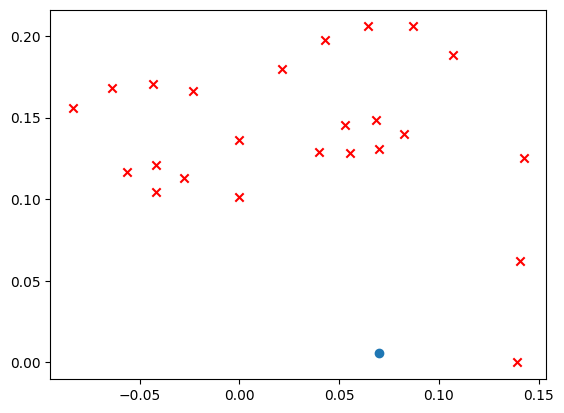

--


In [19]:
def algorithm_kmeans(d_normalized, file, frame, number_clusters):
    all_coordenates = d_normalized[file][frame]

    centroids = []
    for i in range(number_clusters):    
        c = random.choice(all_coordenates)
        if c not in centroids:
            centroids.append(c)
        else:
            i -= 1
    group = cluster_groups(all_coordenates, centroids)

    while(1):
        new_centroids = []
        for i in range(len(centroids)):
            new_centroids.append([np.mean([coord[0] for coord in group[i]]), np.mean([coord[1] for coord in group[i]])])
        new_group = cluster_groups(all_coordenates, centroids)
        if new_group == group:
            break
        else:
            group = new_group
            centroids = new_centroids
    
    return group, centroids


all_file_kmeans = '01-01-02-01-01-01-01.csv'
all_frame_kmeans = 0
all_number_cluster = 2

all_group_centroids, all_centroids = algorithm_kmeans(all_d_normalized, all_file_kmeans, all_frame_kmeans, all_number_cluster)

print(str(all_number_cluster) + " clusters com o algoritmo kmeans")
for i in range(all_number_cluster):
    print("Centroide " + str(i + 1) + ": ", all_centroids[i])
    print("Cluster " + str(i + 1) + ": ", all_group_centroids[i])
    plot_clusters(all_centroids[i], all_group_centroids[i])
    print("--")
    

##### 3.8 Calcular os Outiliers através do k-means

In [20]:
def kmeans_outliers(group_centroids, centroids):
    outliers = []
    for group in group_centroids:
        aux = []
        for coordenates in group_centroids[group]:
            aux.append(distance.euclidean(centroids[group], coordenates))
        mean_group = np.mean(aux)
        for dist in aux:
            if dist > mean_group:
                outliers.append(group_centroids[group][aux.index(dist)])
    return outliers 

all_outliers_kmeans = kmeans_outliers(all_group_centroids, all_centroids)  
print("Outliers com o algoritmo kmeans:") 
print(all_outliers_kmeans)    

Outliers com o algoritmo kmeans:
[[-0.10320312499999998, 0.030694444444444476], [-0.07406249999999996, 0.26361111111111113], [-0.05625, 0.30652777777777784], [-0.03703124999999998, 0.3368055555555556], [-0.015156249999999982, 0.35833333333333334], [0.0140625, 0.36277777777777787], [0.04632812500000005, 0.35527777777777786], [0.07914062500000005, 0.3313888888888889], [0.10593750000000002, 0.2972222222222222], [0.12585937500000002, 0.2513888888888889], [0.136328125, 0.19638888888888895], [-0.09507812499999999, 0.01083333333333335], [-0.06898437499999996, 0.03430555555555562], [-0.056015624999999944, 0.035972222222222267], [0.06921875000000002, 0.20472222222222228], [0.04671875000000005, 0.2294444444444445], [0.025625000000000054, 0.24305555555555555], [0.008359375000000035, 0.24930555555555556], [0.13890625000000006, 0.1365277777777778], [0.14078125000000002, 0.07430555555555556], [-0.08335937499999999, -0.019305555555555524], [-0.06398437499999998, -0.031805555555555524], [-0.0434375000

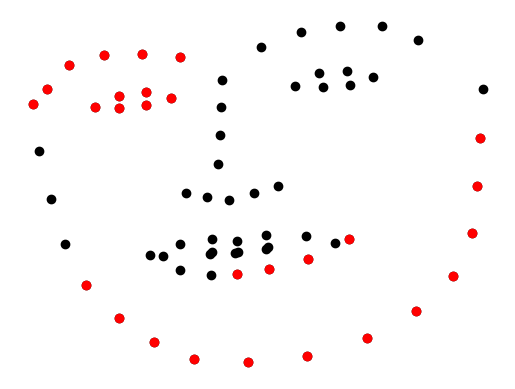

In [21]:
def expression_outliers_kmeans(outliers, d_normalized, file, frame):
    matrix_x = []
    matrix_y = []
    for coordinates in d_normalized[file][frame]:
        matrix_x.append(coordinates[0])
        matrix_y.append(coordinates[1])

    matrix_x = np.array(matrix_x)
    matrix_y = np.array(matrix_y)
    outliers = np.array(outliers)

    len_img = max(matrix_y)
    matrix_y = len_img - matrix_y
    plt.scatter(matrix_x, matrix_y, c = 'black')
    plt.scatter(outliers[ :, 0], len_img - outliers[ :, 1], c = 'red')

    plt.axis('off')
    plt.show()

expression_outliers_kmeans(all_outliers_kmeans, all_d_normalized, all_file_kmeans, all_frame_kmeans)

Comparando com os resultados obtidos em 3.5, para o mesmo ficheiro, o número de outliers aumenta. 

Ao aumentar o número de clusters, o número de outliers decresce, porém, como os centroides são escolhidos aleatoriamente e o algoritmo k_means foi feito por nós, os valores podem não ser os melhores, isto é, pode haver um maior número de outliers do que o expectável.

##### 3.9 Injetar Outliers num array

In [22]:
def create_feature_set(l, d_normalized):
    d = {"emotion": ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']}
    for i in range(l):
        d_boxplot_x = boxplot(d_normalized, 0, i, False)
        d_boxplot_y = boxplot(d_normalized, 1, i, False)
        x = "x_" + str(i)
        y = "y_" + str(i)
        for i in d_boxplot_x:
            if x not in d:
                d[x] = [np.mean(d_boxplot_x[i])]
                d[y] = [np.mean(d_boxplot_y[i])]
            else:
                d[x].append(np.mean(d_boxplot_x[i]))
                d[y].append(np.mean(d_boxplot_y[i]))
    
    df_feature_set = pd.DataFrame(d)

    return df_feature_set

if os.path.exists("dicionary_feature_set.pkl"):
    with open("dicionary_feature_set.pkl", 'rb') as arq:
        all_df_feature_set = pickle.load(arq)
else:
    all_df_feature_set = create_feature_set(68, all_d_normalized)
    with open("dicionary_feature_set.pkl", 'wb') as arq:
        pickle.dump(all_df_feature_set, arq)

display(all_df_feature_set)        

,emotion,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_63,y_63,x_64,y_64,x_65,y_65,x_66,y_66,x_67,y_67
0,Neutral,-0.131162,0.021926,-0.129542,0.087491,-0.124356,0.153127,-0.116784,0.216197,-0.103732,...,0.015450,0.232870,0.042204,0.242242,0.015293,0.246626,0.001045,0.249195,-0.012219,0.247321
1,Calm,-0.129403,0.030971,-0.128686,0.095378,-0.124702,0.160249,-0.117837,0.222726,-0.104937,...,0.015128,0.223177,0.044380,0.233702,0.015035,0.242173,-0.000194,0.244752,-0.014170,0.242825
2,Happy,-0.131317,0.019751,-0.130295,0.085684,-0.126177,0.151762,-0.119211,0.215796,-0.105743,...,0.017007,0.220236,0.050188,0.228459,0.017241,0.251606,0.000029,0.255259,-0.015512,0.252686
3,Sad,-0.130725,0.010067,-0.128586,0.075368,-0.123190,0.140086,-0.115459,0.202753,-0.102567,...,0.017442,0.233400,0.044515,0.240508,0.017335,0.248714,0.002093,0.252064,-0.011911,0.249745
4,Angry,-0.133662,-0.002602,-0.131757,0.063182,-0.126082,0.128891,-0.118423,0.192437,-0.105634,...,0.015217,0.230019,0.041179,0.240982,0.015460,0.255507,0.000608,0.258643,-0.012994,0.255850
5,Fearful,-0.128943,0.012523,-0.127245,0.077910,-0.121751,0.142788,-0.114137,0.205655,-0.101848,...,0.016191,0.234329,0.043217,0.245510,0.016299,0.256733,0.001324,0.259610,-0.012509,0.256970
6,Disgust,-0.129242,-0.004045,-0.127588,0.061112,-0.122729,0.125849,-0.115625,0.188087,-0.103506,...,0.014959,0.220682,0.040998,0.231636,0.015064,0.242651,-0.000828,0.245749,-0.014955,0.242639
7,Surprised,-0.130363,0.007550,-0.128676,0.073025,-0.123328,0.138171,-0.115697,0.201310,-0.102805,...,0.015758,0.231771,0.042623,0.240526,0.015739,0.251337,0.000875,0.254248,-0.012862,0.251670


In [23]:
def inject_outliers(array, x): 
    mean_array = np.mean(array)
    std_array = np.std(array)
    
    density, outliers = density_outliers(array)
    total_ind = []
    while density < x:
        not_outliers = []
        for i in array:
            if i not in outliers:
                not_outliers.append(i)
        numbers = int((x - density) * len(not_outliers))
        random_points = []
        ind = []
        for j in range(numbers):    
            c = random.choice(not_outliers)
            if c not in random_points:
                ind.append(array.index(c))
                total_ind.append(array.index(c))
                k = 1.5
                s = -1 + (random.random() * 2)
                q1 = np.percentile(array, 25)
                q3 = np.percentile(array, 75)
                iqr = q3 - q1
                z = q3 +  k * iqr
                q = random.random() * z
                p = mean_array + s * k * std_array + q
                c += p
                random_points.append(c)
            else:
                j -= 1
        for k in range(len(ind)):
            array[ind[k]] = random_points[k]
        density, outliers = density_outliers(array)    
    return array, total_ind      

##### 3.10 Determinar o modelo linear

In [24]:
def linear_model(x, y):
    x = np.insert(x, 0, 1, axis=1)
    x_transpose = np.transpose(x)
    x_transpose_x = np.dot(x_transpose, x) #4 * 4
    x_transpose_x_inverse = np.linalg.inv(x_transpose_x)
    x_transpose_x_inverse_x = np.dot(x_transpose_x_inverse, x_transpose)
    beta = np.dot(x_transpose_x_inverse_x, y)
    return beta

##### 3.11 Usar 3.9 e 3.10 para um dado landmark

####  4. Extração de informação estatística

##### 4.1 Features relevantes

In [25]:
all_d_file = one_file_coordinates('01-01-01-01-01-01-01.csv')

all_landmarks = [22, 57, 66, 54, 45, 44, 47, 13, 33, 28]

In [26]:
def just_landmarks(d):
    d_landmarks = {}
    for i in all_landmarks:
        for frame in d:
            if i not in d_landmarks:
                d_landmarks[i] = [[d[frame][i][0], d[frame][i][1]]]
            else:
                d_landmarks[i].append([d[frame][i][0], d[frame][i][1]])
    return d_landmarks

all_d_landmarks = just_landmarks(all_d_file)
print(all_d_landmarks)

{22: [[679.7, 258.1], [681.6, 257.4], [681.7, 257.8], [681.9, 258.4], [681.9, 259.0], [681.3, 259.8], [680.8, 260.6], [680.1, 261.2], [679.4, 261.7], [678.7, 262.2], [678.2, 262.4], [677.5, 262.9], [676.7, 263.1], [676.0, 263.3], [675.5, 263.7], [675.0, 263.9], [674.6, 264.2], [674.5, 264.3], [674.2, 264.6], [674.2, 264.9], [673.9, 265.0], [673.8, 265.4], [673.6, 265.4], [673.2, 265.3], [673.0, 264.9], [673.0, 263.7], [672.6, 262.3], [672.1, 261.0], [671.7, 260.4], [671.5, 259.8], [671.1, 259.4], [670.8, 258.8], [671.5, 258.5], [671.1, 258.1], [671.3, 257.7], [672.0, 257.7], [672.6, 257.9], [672.7, 258.7], [672.3, 258.3], [671.7, 257.5], [670.9, 256.2], [670.1, 255.8], [669.8, 255.8], [668.7, 256.3], [666.9, 257.2], [666.0, 257.2], [664.2, 256.3], [662.3, 255.3], [660.2, 254.0], [658.4, 252.5], [656.2, 251.3], [653.8, 251.1], [649.1, 252.0], [647.4, 253.2], [644.9, 254.0], [646.2, 254.5], [646.5, 256.8], [647.2, 258.6], [648.8, 259.9], [649.7, 260.9], [650.1, 261.4], [650.9, 262.3], [6

4.1.1 Média dos landmarks selecionados

In [27]:
def mean_landmarks(d_landmarks):
    d_mean = {}
    for landmark in all_landmarks:
        x = []
        y = []
        for coordinates in d_landmarks[landmark]:
            x.append(coordinates[0])
            y.append(coordinates[1])
        d_mean[landmark] = [np.mean(x), np.mean(y)]      
        
    return d_mean

all_d_mean = mean_landmarks(all_d_landmarks)
print(all_d_mean)

{22: [659.6897959183673, 261.9632653061224], 57: [621.461224489796, 481.7795918367347], 66: [621.3510204081632, 460.2244897959184], 54: [690.2602040816327, 452.8469387755102], 45: [728.4112244897959, 297.33061224489796], 44: [712.1285714285715, 289.3316326530612], 47: [693.8683673469387, 301.95], 13: [775.1285714285715, 430.76224489795914], 33: [622.0316326530613, 403.3989795918368], 28: [624.7061224489795, 316.37448979591835]}


4.1.2 Distância entre landmarks

In [28]:
def distance_landmarks(d, d_landmarks):
    d_distances = {}
   
    for i in range(len(all_landmarks) - 1):
        d_aux = {}
        for j in range(i + 1, len(all_landmarks)):
            for frame in d:
                if all_landmarks[j] not in d_aux:
                    d_aux[all_landmarks[j]] = [distance.euclidean(d_landmarks[all_landmarks[i]][frame], d_landmarks[all_landmarks[j]][frame])]
                else:
                    d_aux[all_landmarks[j]].append(distance.euclidean(d_landmarks[all_landmarks[i]][frame], d_landmarks[all_landmarks[j]][frame]))
        d_distances[all_landmarks[i]] = d_aux
        
    return d_distances  

all_d_distances = distance_landmarks(all_d_file, all_d_landmarks)
print(all_d_distances)  

{22: {57: [217.67886897905365, 218.076248133537, 217.46912424525925, 216.85497457978687, 216.29343494429045, 216.1960684193864, 215.9557825111427, 216.1278556780685, 216.32984075249536, 216.11249385447388, 216.1574657512435, 216.11249385447388, 216.04536560639295, 216.12056820210333, 216.17365704451595, 216.3245016173619, 216.6391700501089, 217.12687535171688, 217.51707978915127, 218.1781382265419, 218.57916186132653, 218.92658586841387, 220.26425039029826, 222.15141232951905, 225.25940601892745, 230.82885434884437, 231.33992305695963, 231.53492177207312, 231.14259668005815, 231.55442124908777, 232.35972112222893, 233.36274338462852, 232.41774889194673, 230.008869394204, 227.8303096605015, 226.14280886201095, 225.84742637453277, 224.61195426779938, 224.92578776120803, 226.00424774769172, 230.36362560091814, 233.45074426953536, 235.7363993955961, 236.49551792793028, 234.68054883181094, 233.15928032141466, 232.87352790731708, 230.1908121537434, 221.65741584706794, 219.32300380944994, 221

In [29]:
def statics_distance(d_distances):
    stats_distance = {}
    for l1 in d_distances:
        for l2 in d_distances[l1]:
            string = str(l1) + "-" + str(l2)
            stats_distance[string] = [np.mean(d_distances[l1][l2]), np.std(d_distances[l1][l2])]
    return stats_distance

all_stats_distance = statics_distance(all_d_distances)
print(all_stats_distance)

{'22-57': [223.27736599181674, 7.402804146113011], '22-66': [202.08397786314663, 4.952877249447223], '22-54': [193.61024048530808, 3.181801510748882], '22-45': [77.51287621980217, 2.5071407673894632], '22-44': [59.43750521261254, 2.573414831808931], '22-47': [52.76960986947392, 1.999619540100443], '22-13': [205.06357166819797, 5.699126605856296], '22-33': [146.46380241245558, 1.9499584578166478], '22-28': [64.7325948751598, 1.542141869207389], '57-66': [21.572868003396568, 2.678931173150481], '57-54': [74.78468695097163, 3.0175482838181495], '57-45': [213.3263605556519, 6.301661121983906], '57-44': [212.85459031539395, 6.354013196919193], '57-47': [193.9535799173063, 6.448719261855665], '57-13': [162.07869377039881, 7.420186556848051], '57-33': [78.47702230581176, 8.130217672416798], '57-28': [165.60152820938015, 7.6979905689408], '66-54': [69.41316180185608, 3.3430417067428895], '66-45': [195.03669554429945, 4.891156465336129], '66-44': [193.62242296111177, 5.11507178066996], '66-47':

4.1.3 Velocidade entre frames para landmarks de interesse

In [30]:
def velocity_landmarks(d_landmarks, file):
    f = pd.read_csv("dataset/" + file)
    time = f["timestamp"]

    d_velocity = {}
    for landmark in d_landmarks:
        d_velocity[landmark] = {}
        for f1 in range(len(d_landmarks[landmark]) - 1):
            d_velocity[landmark][f1] = {}
            for f2 in range(f1 + 1, len(d_landmarks[landmark])):
                d_velocity[landmark][f1][f2] = distance.euclidean(d_landmarks[landmark][f1], d_landmarks[landmark][f2])/(time[f2] - time[f1])
    return d_velocity

all_d_velocity = velocity_landmarks(all_d_landmarks, '01-01-02-01-01-01-01.csv')
print(all_d_velocity)

{22: {0: {1: 61.35895979186827, 2: 30.18469912859209, 3: 22.203603311173776, 4: 17.871976427074216, 5: 13.979182670572943, 6: 13.656500283747478, 7: 13.357691972724451, 8: 13.529881549204719, 9: 14.067298564006018, 10: 13.63508687034203, 11: 14.38733382282728, 12: 14.577379737113251, 13: 14.705082843879165, 14: 14.989293361884368, 15: 14.900704276118981, 16: 14.889701409651078, 17: 14.271554373293798, 18: 14.167542733715809, 19: 13.79472580699441, 20: 13.514060252863567, 21: 13.389671931820079, 22: 12.960693181498913, 23: 12.646675358539754, 24: 11.917856971069233, 25: 10.47017337924041, 26: 9.503735471723678, 27: 9.028295729898016, 28: 8.912271422551061, 29: 8.651204181423324, 30: 8.689011833792039, 31: 8.633931961572868, 32: 7.687032116769252, 33: 7.811080835604018, 34: 7.415801072884963, 35: 6.601354974726491, 36: 5.914085214681041, 37: 5.68879937497985, 38: 5.838093225022704, 39: 6.166386201424007, 40: 6.743653445124117, 41: 7.216137906409982, 42: 7.2545758442666815, 43: 7.76745633

In [31]:
def statics_velocity(d_velocity, d):
    stats_velocity = {}
    med = []
    for f1 in range(len(d) - 1):
        stats_velocity[f1] = {}
        for f2 in range(f1 + 1, len(d)):
            stats_velocity[f1][f2] = {}
            v = []
            for landmark in d_velocity:
                v.append(int(d_velocity[landmark][f1][f2]))
            stats_velocity[f1][f2] = [np.mean(v), np.std(v)]
            med.append(np.mean(v))
    return stats_velocity, med

all_stats_velocity = statics_velocity(all_d_velocity, all_d_file)[0]
print(all_stats_velocity)

{0: {1: [72.2, 55.468549647525485], 2: [49.6, 43.31096858764532], 3: [37.4, 35.62078045186545], 4: [27.6, 27.964978097613454], 5: [21.0, 21.64717071582335], 6: [18.0, 16.2234398325386], 7: [16.2, 12.456323695216017], 8: [15.2, 9.56869897112455], 9: [14.9, 7.621679604916491], 10: [14.4, 6.200000000000001], 11: [14.1, 4.742362280551751], 12: [13.9, 4.323193264243458], 13: [13.8, 3.627671429443411], 14: [13.5, 3.170173496829472], 15: [13.4, 2.90516780926679], 16: [13.3, 2.7586228448267445], 17: [13.1, 2.6248809496813372], 18: [12.6, 2.615339366124404], 19: [12.4, 2.4979991993593593], 20: [11.9, 2.6248809496813377], 21: [11.5, 2.7294688127912363], 22: [11.4, 2.835489375751565], 23: [11.8, 3.3105890714493698], 24: [11.7, 3.950949253027682], 25: [12.1, 5.281098370604358], 26: [11.8, 4.707440918375928], 27: [11.7, 4.148493702538308], 28: [11.0, 3.6606010435446255], 29: [10.9, 3.3301651610693423], 30: [10.5, 3.2015621187164243], 31: [10.1, 3.144837038703278], 32: [8.8, 2.7856776554368237], 33:

##### 4.2 Analisar as estatísticas extraídas

In [32]:
def dicionary_stats(ef):
    d = {}
    for i in ef:
        f = all_d_normalized[i[1]]
        d_landmarks = just_landmarks(f)
        d_distance = distance_landmarks(f, d_landmarks)
        stats_distance = statics_distance(d_distance)
        array_dist = [stats_distance[s][0] for s in stats_distance]
        d_velocity = velocity_landmarks(d_landmarks, i[1])
        df_vel = pd.DataFrame(pd.read_csv("dataset/" + i[1]))
        df_without_nan = df_vel.copy().dropna(how='all')
        stats_velocity = statics_velocity(d_velocity, df_without_nan)[1]

        if i[0] not in d:
            d[i[0]] = {}
            d[i[0]]["Dist"] = [np.mean(array_dist)]
            d[i[0]]["Vel"] = [np.mean(stats_velocity)]

        else:
            d[i[0]]["Dist"].append(np.mean(array_dist))
            d[i[0]]["Vel"].append(np.mean(stats_velocity))


    with open("dicionary_significance.pkl", 'wb') as arq:
        pickle.dump(d, arq)
    return d

if os.path.exists("dicionary_significance.pkl"):
    with open("dicionary_significance.pkl", 'rb') as arq:
        all_significant_stats = pickle.load(arq)
else:
    all_significant_stats = dicionary_stats(all_ef)


In [33]:
def stat_is_significant(d_stats):
    for em in d_stats:
        
        print("Emoção " + em)
        ks_stats_dist, p_value_dist = stats.kstest(d_stats[em]["Dist"], 'norm')
        print("Estatísticas para a distância:\nP value: ", p_value_dist, "\nKS stats: ", ks_stats_dist)
        print("--")
        ks_stats_vel, p_value_vel = stats.kstest(d_stats[em]["Vel"], 'norm')
        print("Estatísticas para a velocidade:\nP value: ", p_value_vel, "\nKS stats: ", ks_stats_vel)
        print("---------------------------------")

stat_is_significant(all_significant_stats)

Emoção Neutral
Estatísticas para a distância:
P value:  2.099064134938802e-55 
KS stats:  0.5568760001303734
--
Estatísticas para a velocidade:
P value:  5.502172420941979e-44 
KS stats:  0.5
---------------------------------
Emoção Calm
Estatísticas para a distância:
P value:  4.623397370935975e-108 
KS stats:  0.5517033744685385
--
Estatísticas para a velocidade:
P value:  1.9044893369874409e-87 
KS stats:  0.5
---------------------------------
Emoção Happy
Estatísticas para a distância:
P value:  1.2126723636077475e-109 
KS stats:  0.5553981310452173
--
Estatísticas para a velocidade:
P value:  1.9044893369874409e-87 
KS stats:  0.5
---------------------------------
Emoção Sad
Estatísticas para a distância:
P value:  2.7074245537133164e-109 
KS stats:  0.5545860879614051
--
Estatísticas para a velocidade:
P value:  1.9044893369874409e-87 
KS stats:  0.5
---------------------------------
Emoção Angry
Estatísticas para a distância:
P value:  2.528980533928711e-109 
KS stats:  0.554655

Neste ponto, foram analisadas, para diferentes emoções, a sua significância através do teste de Kolmogorov-Smirnov ou teste KS. 

Utilizando as estatísticas calculadas anteriormente, como a média das distâncias e das velocidades, para as diferentes emoções, foi-nos possível retirar a significância estat´stica desses valores. 

Desta forma, é possível observar que pelos resultados obtidos em cima, para todas as emoções, a hipótese nula é rejeitada, o que sugere que existe uma diferença significativa entre as distribuições.

##### 4.3 PCA de um feature

In [34]:
def pca(df, n_components):

    target = df["emotion"]
    data = df.drop("emotion", axis = 1).values
    
    
    pca = PCA(n_components=n_components)
    principal_comp = pca.fit_transform(data)
    
    columns = ["Componente principal " + str(i + 1) for i in range(len(pca.explained_variance_ratio_))]
    print("Variância de cada componente: ", pca.explained_variance_ratio_)
    df_pca = pd.DataFrame(data=principal_comp, columns=columns)
    pca_table = pd.concat([target, df_pca], axis = 1)
    return pca_table

all_pca_table = pca(all_df_feature_set, 2)

display(all_pca_table)

Variância de cada componente:  [0.63643431 0.24015798]


,emotion,Componente principal 1,Componente principal 2
0,Neutral,0.030347,-0.014992
1,Calm,0.068947,0.021398
2,Happy,0.041420,0.013026
3,Sad,-0.018524,-0.012271
4,Angry,-0.051170,-0.009700
5,Fearful,-0.002540,-0.034872
6,Disgust,-0.051473,0.050365
7,Surprised,-0.017007,-0.012954


Como podemos observar, as duas componenetes juntas conseguem conter aproximadamente 83% de informação.

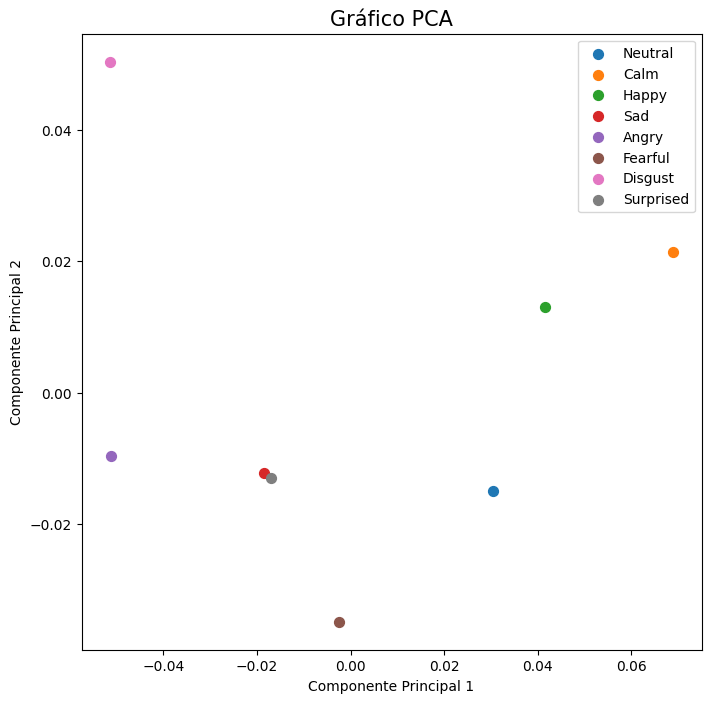

In [35]:
def pca_graph(pca_table):
    plt.figure(figsize = (8,8))
    plt.xlabel("Componente Principal 1", fontsize = 10)
    plt.ylabel("Componente Principal 2", fontsize = 10)
    plt.title("Gráfico PCA", fontsize = 15)

    targets = np.array(pca_table["emotion"])
    for t in targets:
        index_line = pca_table.index[pca_table['emotion'] == t].tolist()[0]
        x = pca_table['Componente principal 1'][index_line]
        y = pca_table['Componente principal 2'][index_line]
        plt.scatter(x, y, s = 50)
    plt.legend(targets)
    plt.show()

pca_graph(all_pca_table)

##### 4.4 Importância de cada vetor na explicação da variabilidade do espaço de features

In [36]:
def normalize_zscore(array):
    return [((x - np.mean(array))/np.std(array)) for x in array]

In [37]:
def nomalize_coordinates_zcore(d):    
    for file in d:
        for c in range(2):
            for landmarks in range(68):
                array = []
                for frame in d[file]:
                    array.append(d[file][frame][landmarks][c])
                new_array = normalize_zscore(array)
                for frame in d[file]:
                    d[file][frame][landmarks][c] = new_array[frame]
    
    with open("dicionary_normalized_zscore.pkl", 'wb') as arq:
        pickle.dump(d, arq)
    return d           
   
if os.path.exists("dicionary_normalized_zscore.pkl"):
    with open("dicionary_normalized_zscore.pkl", 'rb') as arq:
        all_d_normalized_zcore = pickle.load(arq)
else:
    all_d_normalized_zcore = nomalize_coordinates_zcore(all_d)


    

In [38]:
all_feature_set_zcore = create_feature_set(68, all_d_normalized_zcore)
display(all_df_feature_set)

,emotion,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_63,y_63,x_64,y_64,x_65,y_65,x_66,y_66,x_67,y_67
0,Neutral,-0.131162,0.021926,-0.129542,0.087491,-0.124356,0.153127,-0.116784,0.216197,-0.103732,...,0.015450,0.232870,0.042204,0.242242,0.015293,0.246626,0.001045,0.249195,-0.012219,0.247321
1,Calm,-0.129403,0.030971,-0.128686,0.095378,-0.124702,0.160249,-0.117837,0.222726,-0.104937,...,0.015128,0.223177,0.044380,0.233702,0.015035,0.242173,-0.000194,0.244752,-0.014170,0.242825
2,Happy,-0.131317,0.019751,-0.130295,0.085684,-0.126177,0.151762,-0.119211,0.215796,-0.105743,...,0.017007,0.220236,0.050188,0.228459,0.017241,0.251606,0.000029,0.255259,-0.015512,0.252686
3,Sad,-0.130725,0.010067,-0.128586,0.075368,-0.123190,0.140086,-0.115459,0.202753,-0.102567,...,0.017442,0.233400,0.044515,0.240508,0.017335,0.248714,0.002093,0.252064,-0.011911,0.249745
4,Angry,-0.133662,-0.002602,-0.131757,0.063182,-0.126082,0.128891,-0.118423,0.192437,-0.105634,...,0.015217,0.230019,0.041179,0.240982,0.015460,0.255507,0.000608,0.258643,-0.012994,0.255850
5,Fearful,-0.128943,0.012523,-0.127245,0.077910,-0.121751,0.142788,-0.114137,0.205655,-0.101848,...,0.016191,0.234329,0.043217,0.245510,0.016299,0.256733,0.001324,0.259610,-0.012509,0.256970
6,Disgust,-0.129242,-0.004045,-0.127588,0.061112,-0.122729,0.125849,-0.115625,0.188087,-0.103506,...,0.014959,0.220682,0.040998,0.231636,0.015064,0.242651,-0.000828,0.245749,-0.014955,0.242639
7,Surprised,-0.130363,0.007550,-0.128676,0.073025,-0.123328,0.138171,-0.115697,0.201310,-0.102805,...,0.015758,0.231771,0.042623,0.240526,0.015739,0.251337,0.000875,0.254248,-0.012862,0.251670


In [39]:
pca(all_feature_set_zcore, 0.75)

Variância de cada componente:  [0.44359994 0.19006823 0.10491114 0.08825326]


,emotion,Componente principal 1,Componente principal 2,Componente principal 3,Componente principal 4
0,Neutral,1.428220e-14,5.049130e-16,-8.322788e-17,5.825283e-16
1,Calm,-1.925092e-15,-2.111146e-15,8.306595e-17,8.746891e-17
2,Happy,-2.399177e-15,-7.114732e-16,-8.280782e-16,1.964048e-15
3,Sad,-1.081780e-15,-3.649378e-15,-3.242332e-15,-4.019633e-15
4,Angry,-1.765827e-15,-1.976747e-15,-8.316181e-16,-7.458677e-17
5,Fearful,-3.130380e-15,3.286350e-16,-9.434391e-16,4.622237e-15
6,Disgust,-1.564004e-15,-1.166912e-15,6.520748e-15,-1.278703e-15
7,Surprised,-2.415945e-15,8.782108e-15,-6.751195e-16,-1.883359e-15



**Vantagens**:

- Reduz o número de features originais, mas tentando sempre manter a maior quantidade possível de informação;

- Eliminação de features que não iriam ser necessárias para os algoritmos usados;

**Desvantagens**:

- Ao reduzir o número de features, pode ocorrer perda de informação, pois não sabemos se as 10 features usaddas são mesmo as ideias. Isto só é possível fazendo vários testes.

##### 4.5 Top 10 features

In [40]:
def create_df():
    d = {"emotion": []}
    verify = True
    for i in range(68):
        d_boxplot_x = boxplot(all_d_normalized, 0, i, False)
        d_boxplot_y = boxplot(all_d_normalized, 1, i, False)
        for e in d_boxplot_x:
            for m in range(len(d_boxplot_x[e])):

                if i not in d:
                    d[i] = [(d_boxplot_x[e][m] + d_boxplot_y[e][m]) / 2]
                else:
                    d[i].append((d_boxplot_x[e][m] + d_boxplot_y[e][m]) / 2)
                if verify:
                    d["emotion"].append(number_emotions[e])
        verify = False
                    
    df_feature_set = pd.DataFrame(d)
    return df_feature_set

if os.path.exists("dataframe.pkl"):
    with open("dataframe.pkl", 'rb') as arq:
        all_df_feature_set = pickle.load(arq)
else:
    all_df_feature_set = create_df()
    with open("dataframe.pkl", 'wb') as arq:
        pickle.dump(all_df_feature_set, arq)

display(all_df_feature_set)


,emotion,0,1,2,3,4,5,6,7,8,...,58,59,60,61,62,63,64,65,66,67
0,Neutral,-0.053822,-0.023154,0.008805,0.040564,0.073761,0.107105,0.137255,0.164971,0.185473,...,0.122985,0.108614,0.091570,0.105059,0.112867,0.119007,0.135364,0.122205,0.116026,0.108283
1,Neutral,-0.058963,-0.026069,0.007644,0.040454,0.073445,0.105956,0.135662,0.163319,0.182336,...,0.129046,0.114958,0.097495,0.107814,0.114432,0.119498,0.133379,0.125483,0.120395,0.113379
2,Neutral,-0.079030,-0.046571,-0.012298,0.022543,0.060805,0.099898,0.135804,0.168860,0.190229,...,0.127063,0.111485,0.094634,0.105516,0.113922,0.120849,0.137095,0.126455,0.119769,0.110918
3,Neutral,-0.059558,-0.025805,0.009919,0.044679,0.078976,0.111428,0.138487,0.163225,0.181664,...,0.121482,0.105793,0.087892,0.100403,0.108535,0.115370,0.133358,0.120948,0.114114,0.105832
4,Neutral,-0.052601,-0.017336,0.019638,0.056554,0.093591,0.131722,0.167617,0.201276,0.225411,...,0.151956,0.135286,0.114733,0.126967,0.135077,0.141615,0.161045,0.147150,0.140850,0.132452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,Surprised,-0.054063,-0.025722,0.004655,0.034966,0.065658,0.095805,0.122293,0.147085,0.164924,...,0.109671,0.097747,0.082634,0.090263,0.096448,0.101791,0.120907,0.108750,0.102968,0.096448
2448,Surprised,-0.054209,-0.022116,0.012016,0.047077,0.081880,0.116135,0.147808,0.175550,0.193313,...,0.141470,0.124681,0.101166,0.105876,0.112581,0.117865,0.134857,0.136840,0.132075,0.124097
2449,Surprised,-0.055422,-0.019728,0.018040,0.055118,0.091582,0.127558,0.159598,0.189877,0.213078,...,0.142708,0.127716,0.109901,0.112924,0.120394,0.127074,0.150223,0.138831,0.132009,0.123767
2450,Surprised,-0.047773,-0.012581,0.025514,0.064692,0.102540,0.139751,0.171812,0.199671,0.219314,...,0.142600,0.130621,0.115342,0.123118,0.129821,0.135091,0.153833,0.139898,0.134356,0.127323


In [41]:
all_data = all_df_feature_set.drop("emotion", axis=1).values
all_target = all_df_feature_set["emotion"].values

Fisher Score

In [42]:
def features_fisher_score(data, target):
    return fisher_score.fisher_score(data, target)

all_fisher_score = features_fisher_score(all_data, all_target)

print("Top 10 features de acordo com o Fisher Score:")
print(all_fisher_score[:10])

Top 10 features de acordo com o Fisher Score:
[24 19 29  7 30 25 18 46 67 51]


ReliefF

In [43]:
def features_reliefF(data, target):
    relief = ReliefF(n_features_to_keep=10)
    relief.fit_transform(data, target)
    return relief.top_features

all_relieff = features_reliefF(all_data, all_target)

print("Top 10 features de acordo com o ReliefF:")
print(all_relieff[:10])

Top 10 features de acordo com o ReliefF:
[67 16 31 30 29 28 26 25 24 23]


##### 4.6 Vantagens e Desvantagens

**Vantagens**:

- Redução da memória utilizada, assim como do tempo de execução do código, pois existem menos features;

- Eliminação de features que não iriam ser necessárias para os algoritmos usados;

**Desvantagens**:

- Ao reduzir o número de features, pode ocorrer perda de informação, pois não sabemos se as 10 features usaddas são mesmo as ideias. Isto só é possível fazendo vários testes.